In [1]:
import os
import pandas as pd
import plotly.express as px


from PIL import Image
from collections import defaultdict

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
project_folder = '/gdrive/MyDrive/ProjectCIRI'

In [4]:
dataset_path = project_folder + '/Incidents-subset/'

In [ ]:
images_data = defaultdict(list)

for class_name in os.listdir(dataset_path):
  class_path = os.path.join(dataset_path, class_name)

  if os.path.isdir(class_path):
    for image_name in os.listdir(class_path):
      image_path = os.path.join(class_path, image_name)
      # Verify it's image
      try:
        with Image.open(image_path) as img:
            img.verify()
        images_data['label'].append(class_name)
        images_data['img_path'].append(image_name)
        images_data['can_be_opened'].append(True)
        images_data['errors'].append(None)
        with Image.open(image_path) as img:
          width, height = img.size
        images_data['width'].append(width)
        images_data['height'].append(height)
      except (IOError, SyntaxError) as e:
        print(e)
        images_data['label'].append(class_name)
        images_data['img_path'].append(image_name)
        images_data['can_be_opened'].append(False)
        images_data['errors'].append(str(e))
        images_data['width'].append(None)
        images_data['height'].append(None)

images_summary = pd.DataFrame.from_dict(images_data)
images_summary

In [ ]:
images_summary.to_csv(os.path.join(project_folder, 'out', 'dataset_issues_summary.csv'), index=False)

In [5]:
images_summary = pd.read_csv(os.path.join(project_folder, 'out', 'dataset_issues_summary.csv'))

In [6]:
images_summary.loc[images_summary['can_be_opened'] == True].shape

(7358, 6)

In [8]:
images_summary[images_summary['can_be_opened'] == False]

,label,img_path,can_be_opened,errors,width,height
281,tornado,.DS_Store,False,cannot identify image file '/gdrive/MyDrive/Pr...,NaN,NaN
330,airplane accident,.hashed.6f95947e.desktop.story.share.jpg,False,cannot identify image file '/gdrive/MyDrive/Pr...,NaN,NaN
636,airplane accident,AR-190939882.jpg,False,cannot identify image file '/gdrive/MyDrive/Pr...,NaN,NaN
1156,airplane accident,.DS_Store,False,cannot identify image file '/gdrive/MyDrive/Pr...,NaN,NaN
1558,earthquake,.hashed.909e0e37.desktop.story.share.jpg,False,cannot identify image file '/gdrive/MyDrive/Pr...,NaN,NaN
2082,earthquake,.DS_Store,False,cannot identify image file '/gdrive/MyDrive/Pr...,NaN,NaN
2771,collapsed,.DS_Store,False,cannot identify image file '/gdrive/MyDrive/Pr...,NaN,NaN
3003,nuclear explosion,.DS_Store,False,cannot identify image file '/gdrive/MyDrive/Pr...,NaN,NaN
3970,car accident,.DS_Store,False,cannot identify image file '/gdrive/MyDrive/Pr...,NaN,NaN
4532,flooded,.53_format=1.7777777777777777__image.jpg,False,cannot identify image file '/gdrive/MyDrive/Pr...,NaN,NaN


In [9]:
images_summary[images_summary['can_be_opened'] == False].shape

(19, 6)

In [10]:
class_freq_plot = px.histogram(images_summary[images_summary['can_be_opened'] == True], x='label', text_auto=True)
class_freq_plot.show()

In [ ]:
class_counts = images_summary[images_summary['can_be_opened'] == True]['label'].value_counts()
class_counts = class_counts.to_frame()
class_counts['needed'] = 1000 - class_counts['count']
class_counts

,count,needed
label,,
car accident,966,34
flooded,957,43
earthquake,924,76
airplane accident,872,128
collapsed,688,312
wildfire,676,324
volcanic eruption,627,373
ice storm,615,385
oil spill,293,707


In [ ]:
dim_scatter = px.scatter(
    images_summary[images_summary['can_be_opened'] == True],
    x='width', y='height', color='label', opacity=.6, marginal_x='histogram',
    marginal_y='histogram')
dim_scatter.show()

In [ ]:
images_summary[images_summary['can_be_opened'] == True][['width', 'height']].mean()

width     999.156428
height    693.986138
dtype: float64

In [ ]:
augmented_images_path = os.path.join(project_folder, "augmented_images")
os.makedirs(augmented_images_path, exist_ok=True)

In [ ]:
from torchvision.transforms import v2
from torchvision.io import read_image, ImageReadMode
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from itertools import cycle

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

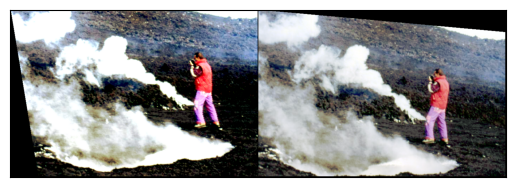

In [ ]:
test_transform = v2.Compose([v2.AutoAugment(), v2.RandAugment()])
test_image = read_image(os.path.join(dataset_path, "volcanic eruption", "0802_2000_09.jpg"))
transf_image = [test_transform(test_image) for _ in range(0,2)]

grid = make_grid(transf_image)
show(grid)

In [ ]:
def apply_aug(image_path, transforms, out_folder, file_name):
  try:
    img = read_image(image_path)
  except RuntimeError:
    return None
  transformed_img = None
  while transformed_img is None:
    try:
      transformed_img = transforms(img)
    except:
      continue
  if file_name:
    (F.to_pil_image(transformed_img)).save(os.path.join(out_folder, file_name))
    #save_image(transformed_img, os.path.join(out_folder, file_name))
  return transformed_img

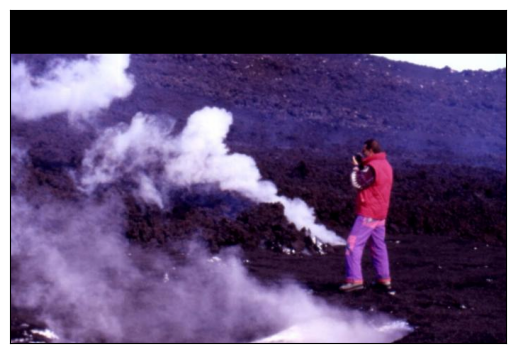

In [ ]:
show(make_grid(apply_aug(os.path.join(dataset_path, "volcanic eruption", "0802_2000_09.jpg"), test_transform, None, None)))

In [ ]:
def augument_dataset(class_counts, images_summary, augument_path):
  aug_list = [
      v2.AutoAugment()
  ]

  interm_augm = [
      v2.RandAugment()
  ]

  heavy_augm = [
      v2.RandAugment(),
      v2.AugMix()
  ]

  full_paths = images_summary.loc[:, ['label', 'img_path']]
  full_paths['full_path'] = full_paths.apply(
      lambda x: os.path.join(dataset_path, x['label'], x['img_path']), axis=1)

  for label, row in class_counts.iterrows():
    needed = row['needed']
    print(f"Augumenting class {label}...")
    class_out_folder = os.path.join(augument_path, label)
    os.makedirs(class_out_folder, exist_ok=True)

    if needed < 150:
      img_transforms = v2.Compose(aug_list)
    elif needed < 400:
      img_transforms = v2.Compose(aug_list + interm_augm)
    else:
      img_transforms = v2.Compose(aug_list + heavy_augm)

    img_path_iter = cycle(full_paths[full_paths['label'] == label]['full_path'])
    i = 0
    while i < needed:
      print(f"{i+1}/{needed}...\r", end='', flush=True)
      filename = f'{i}.{label}_augmented.png'
      res_image = apply_aug(next(img_path_iter),
                            img_transforms, class_out_folder, filename)
      if res_image is not None:
        i += 1

In [ ]:
augument_dataset(class_counts,
                 images_summary.loc[images_summary['can_be_opened'] == True],
                 augmented_images_path)

Augumenting class car accident...
Augumenting class flooded...
Augumenting class earthquake...
Augumenting class airplane accident...
Augumenting class collapsed...
Augumenting class wildfire...
Augumenting class volcanic eruption...
Augumenting class ice storm...
Augumenting class oil spill...
Augumenting class tornado...
Augumenting class nuclear explosion...
Augumenting class bicycle accident...


# Plots

In [56]:
import plotly.graph_objects as go

In [12]:
ciri_util_pkg = os.path.join(project_folder, "code", "ciri_utils")

In [13]:
!pip install $ciri_util_pkg

Processing /gdrive/MyDrive/ProjectCIRI/code/ciri_utils
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 775.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 1.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-m

In [7]:
!pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 12.9 MB/s eta 0:00:00


In [8]:
out_folder = os.path.join(project_folder, 'out')

In [41]:
before_df = images_summary.loc[images_summary['can_be_opened'] == True].copy()
before_df['label'] = before_df['label'].str.upper()

class_freq_plot_before = px.histogram(
    before_df,
    x='label', template='simple_white', color_discrete_sequence=['#ffcd82'])
class_freq_plot_before.update_layout(
    title={
        'text': 'Number of images per category'.upper(),
        'x': 0.5,
        'font': {
            'size': 30
        }
    },
    font={
        'family': 'Barlow, sans-serif',
        'size': 14
    },
    yaxis_title='COUNT',
    xaxis_title='',
    width=500*2,
    height=400*2
)
class_freq_plot_before.update_xaxes(
    tickangle=50,
    categoryorder='total ascending'
)
class_freq_plot_before.show()

In [11]:
class_freq_plot_before.write_image(file=os.path.join(out_folder, 'before_category_count.jpg'), scale=2)

In [14]:
from ciri_utils import datautils

root_base = os.path.join(project_folder, 'Incidents-subset') # Base images
root_augmented = os.path.join(project_folder, 'augmented_images') # Folder with augmented images

ciri_dataset = datautils.CIRI_Dataset(root=root_base, root_augmented=root_augmented)

# If you want to get tensors directly do instead
ciri_dataset = datautils.CIRI_Dataset(root=root_base, root_augmented=root_augmented)

In [35]:
after_df = ciri_dataset.class_counts.copy().to_frame().reset_index()
after_df = after_df.rename(columns={'label_str': 'label'})
after_df['label'] = after_df['label'].str.upper()

In [42]:
class_freq_plot_after = px.histogram(
    after_df,
    x='label',
    y='count',
    template='simple_white',
    color_discrete_sequence=['#ffcd82'])
class_freq_plot_after.update_layout(
    title={
        'text': 'Number of images per category'.upper(),
        'x': 0.5,
        'font': {
            'size': 30
        }
    },
    font={
        'family': 'Barlow, sans-serif',
        'size': 14
    },
    yaxis_title='COUNT',
    xaxis_title='',
    width=500*2,
    height=400*2
)
class_freq_plot_after.update_xaxes(
    tickangle=50,
    categoryorder='array',
    categoryarray=['BICYCLE ACCIDENT', 'NUCLEAR EXPLOSION',
                   'TORNADO', 'OIL SPILL',
                   'ICE STORM', 'VOLCANIC ERUPTION',
                   'WILDFIRE', 'COLLAPSED',
                   'AIRPLANE ACCIDENT', 'EARTHQUAKE',
                   'FLOODED', 'CAR ACCIDENT']
)
class_freq_plot_after.show()

In [44]:
class_freq_plot_after.write_image(file=os.path.join(out_folder, 'after_category_count.jpg'), scale=2)

In [49]:
cv_data_resnet50 = []

for i in range(5):
  progress_path = os.path.join(project_folder, 'checkpoints',
                               'CV_resnet50', f'resnet50_cv_outer_{i}',
                               'progress.csv')
  df = pd.read_csv(progress_path, index_col=False)
  df['fold'] = i
  cv_data_resnet50.append(df)

cv_data_resnet50 = pd.concat(cv_data_resnet50)
cv_data_resnet50

,loss,accuracy,confusion_matrix,precision,recall,f1,timestamp,checkpoint_dir_name,should_checkpoint,done,...,hostname,node_ip,time_since_restore,iterations_since_restore,summary/epoch/0,summary/train_loss/0,summary/train_acc/0,summary/val_loss/0,summary/val_acc/0,fold
0,2.038733,0.287380,"(array([[ 13, 15, 18, 42, 3, 23, 22, 1...",0.320954,0.287380,0.251329,1713092259,checkpoint_000000,True,False,...,7e23a1ffa89c,172.28.0.12,3046.325445,1,1.0,2.177584,0.270757,2.038733,0.28738,0
1,1.874325,0.366514,"(array([[ 31, 4, 97, 18, 0, 10, 14, ...",0.409791,0.366514,0.346722,1713092739,checkpoint_000001,True,False,...,7e23a1ffa89c,172.28.0.12,3526.252208,2,1.0,2.177584,0.270757,2.038733,0.28738,0
2,1.703165,0.426905,"(array([[ 72, 14, 7, 5, 27, 34, 13, ...",0.431538,0.426905,0.408209,1713093225,checkpoint_000002,True,False,...,7e23a1ffa89c,172.28.0.12,4012.869258,3,1.0,2.177584,0.270757,2.038733,0.28738,0
3,1.669228,0.427322,"(array([[ 28, 7, 3, 23, 54, 21, 7, ...",0.460559,0.427322,0.409027,1713093709,checkpoint_000003,True,False,...,7e23a1ffa89c,172.28.0.12,4496.092715,4,1.0,2.177584,0.270757,2.038733,0.28738,0
4,1.671816,0.446481,"(array([[ 39, 27, 39, 4, 14, 33, 20, ...",0.497733,0.446481,0.428512,1713094195,checkpoint_000004,True,False,...,7e23a1ffa89c,172.28.0.12,4982.098844,5,1.0,2.177584,0.270757,2.038733,0.28738,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,1.463460,0.576250,"(array([[ 96, 15, 37, 13, 9, 7, 3, ...",0.605068,0.576250,0.576314,1713138440,checkpoint_000015,True,False,...,7e23a1ffa89c,172.28.0.12,7647.444716,16,1.0,2.154910,0.270313,2.980350,0.32000,4
16,1.381666,0.600000,"(array([[119, 3, 13, 25, 8, 17, 5, ...",0.635825,0.600000,0.605842,1713138928,checkpoint_000016,True,False,...,7e23a1ffa89c,172.28.0.12,8134.598629,17,1.0,2.154910,0.270313,2.980350,0.32000,4
17,1.558239,0.598333,"(array([[102, 19, 33, 4, 10, 9, 5, ...",0.607692,0.598333,0.594117,1713139423,checkpoint_000017,True,False,...,7e23a1ffa89c,172.28.0.12,8629.952462,18,1.0,2.154910,0.270313,2.980350,0.32000,4
18,1.529727,0.595833,"(array([[ 72, 2, 21, 6, 24, 13, 20, ...",0.616935,0.595833,0.583492,1713139912,checkpoint_000018,True,False,...,7e23a1ffa89c,172.28.0.12,9118.400379,19,1.0,2.154910,0.270313,2.980350,0.32000,4


In [48]:
cv_data_wide_resnet50 = []

for i in range(5):
  progress_path = os.path.join(project_folder, 'checkpoints',
                               'CV_wide_resnet50_2', f'wide_resnet50_cv_outer_{i}',
                               'progress.csv')
  df = pd.read_csv(progress_path, index_col=False)
  df['fold'] = i
  cv_data_wide_resnet50.append(df)

cv_data_wide_resnet50 = pd.concat(cv_data_wide_resnet50)
cv_data_wide_resnet50

,loss,accuracy,confusion_matrix,precision,recall,f1,timestamp,checkpoint_dir_name,should_checkpoint,done,...,hostname,node_ip,time_since_restore,iterations_since_restore,summary/epoch/0,summary/train_loss/0,summary/train_acc/0,summary/val_loss/0,summary/val_acc/0,fold
0,1.910121,0.336110,"(array([[ 19, 3, 75, 13, 3, 10, 3, ...",0.399373,0.336110,0.312811,1713095364,checkpoint_000000,True,False,...,9fc72e07e3ae,172.28.0.12,5758.823765,1,1.0,2.045077,0.301802,1.910121,0.336110,0
1,1.744188,0.395668,"(array([[ 59, 26, 32, 25, 1, 19, 4, ...",0.440765,0.395668,0.385335,1713095860,checkpoint_000001,True,False,...,9fc72e07e3ae,172.28.0.12,6251.437109,2,1.0,2.045077,0.301802,1.910121,0.336110,0
2,1.690768,0.440650,"(array([[ 90, 20, 60, 1, 2, 9, 8, ...",0.469548,0.440650,0.424801,1713096356,checkpoint_000002,True,False,...,9fc72e07e3ae,172.28.0.12,6746.882747,3,1.0,2.045077,0.301802,1.910121,0.336110,0
3,1.553589,0.493128,"(array([[ 87, 8, 20, 1, 19, 20, 11, ...",0.509574,0.493128,0.478007,1713096847,checkpoint_000003,True,False,...,9fc72e07e3ae,172.28.0.12,7237.779521,4,1.0,2.045077,0.301802,1.910121,0.336110,0
4,1.497329,0.505623,"(array([[ 95, 6, 13, 2, 39, 2, 10, ...",0.548190,0.505623,0.497273,1713097338,checkpoint_000004,True,False,...,9fc72e07e3ae,172.28.0.12,7728.659275,5,1.0,2.045077,0.301802,1.910121,0.336110,0
0,1.973913,0.356250,"(array([[ 8, 4, 15, 50, 13, 47, 9, ...",0.436170,0.356250,0.338873,1713097880,checkpoint_000000,True,False,...,9fc72e07e3ae,172.28.0.12,516.573570,1,1.0,2.076485,0.286979,1.973913,0.356250,1
1,1.719536,0.425000,"(array([[ 29, 8, 69, 11, 27, 15, 8, ...",0.436454,0.425000,0.403723,1713098381,checkpoint_000001,True,False,...,9fc72e07e3ae,172.28.0.12,1016.369532,2,1.0,2.076485,0.286979,1.973913,0.356250,1
2,1.736416,0.438333,"(array([[100, 17, 25, 2, 1, 7, 1, ...",0.501864,0.438333,0.416847,1713098883,checkpoint_000002,True,False,...,9fc72e07e3ae,172.28.0.12,1517.924964,3,1.0,2.076485,0.286979,1.973913,0.356250,1
3,1.478392,0.497917,"(array([[ 72, 5, 18, 46, 11, 15, 1, ...",0.539545,0.497917,0.502978,1713099383,checkpoint_000003,True,False,...,9fc72e07e3ae,172.28.0.12,2022.167323,4,1.0,2.076485,0.286979,1.973913,0.356250,1
4,1.583998,0.482917,"(array([[ 57, 35, 5, 5, 36, 25, 8, ...",0.534218,0.482917,0.479993,1713099883,checkpoint_000004,True,False,...,9fc72e07e3ae,172.28.0.12,2518.280223,5,1.0,2.076485,0.286979,1.973913,0.356250,1


In [50]:
cv_data_resnet50['model'] = 'ResNet50'
cv_data_wide_resnet50['model'] = 'Wide ResNet50'

cv_data = pd.concat([cv_data_resnet50, cv_data_wide_resnet50])

In [81]:
means = [cv_data[cv_data['model'] == 'ResNet50']['accuracy'].mean() * 100,
             cv_data[cv_data['model'] == 'Wide ResNet50']['accuracy'].mean() * 100]

acc_plot = go.Figure()
acc_plot.add_trace(
    go.Bar(
        x = ['ResNet50', 'Wide ResNet50'],
        y = means,
        marker_color='#bdacfa',
        error_y=dict(type='data', symmetric=False,
                     array=[(cv_data[cv_data['model'] == 'ResNet50']['accuracy'].max() * 100 - means[0]),
                            cv_data[cv_data['model'] == 'Wide ResNet50']['accuracy'].max() * 100 - means[1]],
                     arrayminus=[means[0] - cv_data[cv_data['model'] == 'ResNet50']['accuracy'].min() * 100,
                            means[1] - cv_data[cv_data['model'] == 'Wide ResNet50']['accuracy'].min() * 100])
    )
)
acc_plot.update_layout(
    title={
        'text': 'Average accuracy per model'.upper(),
        'x': 0.5,
        'font': {
            'size': 30
        }
    },
    font={
        'family': 'Barlow, sans-serif',
        'size': 20
    },
    yaxis_title='%',
    xaxis_title='',
    width=500*2,
    height=400*2,
    template='plotly_white'
)

acc_plot.show()

In [82]:
acc_plot.write_image(file=os.path.join(out_folder, 'acc_plot_base.jpg'), scale=2)

In [ ]:
tl_data_resnet50 = pd.read_csv(os.path.join(project_folder,
                                                 'checkpoints', 'TransferLearning_resnet50',
                                                 'progress.csv'))
tl_data_resnet50['model'] = 'ResNet50'
tl_data_wide_resnet50 = pd.read_csv(os.path.join(project_folder,
                                                 'checkpoints', 'TransferLearning_wide_resnet50',
                                                 'progress.csv'))
tl_data_wide_resnet50['model'] = 'Wide ResNet50'
tl_data = pd.concat([tl_data_resnet50, tl_data_wide_resnet50])

In [83]:
acc_plot_ext = go.Figure()
acc_plot_ext.add_trace(
    go.Bar(
        name='Training on dataset only',
        x = ['ResNet50', 'Wide ResNet50'],
        y = means,
        marker_color='#cdd9de',
        error_y=dict(type='data', symmetric=False,
                     array=[cv_data[cv_data['model'] == 'ResNet50']['accuracy'].max() * 100 - means[0],
                            cv_data[cv_data['model'] == 'Wide ResNet50']['accuracy'].max() * 100 - means[1]],
                     arrayminus=[means[0] - cv_data[cv_data['model'] == 'ResNet50']['accuracy'].min() * 100,
                            means[1] - cv_data[cv_data['model'] == 'Wide ResNet50']['accuracy'].min() * 100])
    )
)

means_tl = [tl_data[tl_data['model'] == 'ResNet50']['accuracy'].mean() * 100,
             tl_data[tl_data['model'] == 'Wide ResNet50']['accuracy'].mean() * 100]
acc_plot_ext.add_trace(
    go.Bar(
        name='With transfer learning',
        x=['ResNet50', 'Wide ResNet50'],
        y=means_tl,
        marker_color='#9bdeac',
        error_y=dict(type='data', symmetric=False,
                     array=[tl_data[tl_data['model'] == 'ResNet50']['accuracy'].max() * 100 - means_tl[0],
                            tl_data[tl_data['model'] == 'Wide ResNet50']['accuracy'].max() * 100 - means_tl[1]],
                     arrayminus=[means_tl[0] - tl_data[tl_data['model'] == 'ResNet50']['accuracy'].min() * 100,
                            means_tl[1] - tl_data[tl_data['model'] == 'Wide ResNet50']['accuracy'].min() * 100])
    )
)

acc_plot_ext.update_layout(
    title={
        'text': 'Average accuracy per model'.upper(),
        'x': 0.5,
        'font': {
            'size': 30
        }
    },
    font={
        'family': 'Barlow, sans-serif',
        'size': 20
    },
    yaxis_title='%',
    xaxis_title='',
    width=500*2,
    height=400*2,
    template='plotly_white',
    legend=dict(orientation='h', x=0.5)
)


In [84]:
acc_plot_ext.write_image(file=os.path.join(out_folder, 'acc_plot_extended.jpg'), scale=2)